# Get user information 

This code is heavily taken from Brian Keegan's script, "Analysis_2017.ipynb", shared in 2020. It relies on wikifunctions.py, also shared by Brian Keegan. Sohyeon Hwang put together this .ipynb in July + August 2020

In [2]:
import argparse
import re, random, urllib, simplejson, copy, itertools
import urllib.parse, urllib.request, urllib.error
from datetime import datetime
# urllib.parse, urllib.request and urllib.error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')

import requests, json, time, os
from pathlib import Path
from copy import deepcopy

import networkx as nx
from operator import itemgetter
from collections import Counter
from bs4 import BeautifulSoup

import wikifunctions as wf

from multiprocessing import Pool, Manager, Process, cpu_count
from functools import partial

In [3]:
# Some helpful structures
"""
Subject Talk    Name        Description
0       1       Main        Articles, lists, & redirects
2       3       User        User pages & sandboxes
4       5       Wikipedia   Policy, essay, & processes
-6       7       File        Media file descriptions
-8       9       MediaWiki   Auto-generated pages
10      11      Template    Infoboxes, nav boxes
-12      13      Help        Software help
14      15      Category    Categorized pages
100     101     Portal      Topics & WikiProjects
"""
langs = ["de","en","es","fr","ja"]
namespaces = [0, 1, 2, 3, 4, 5, 10, 11, 14, 15, 100, 101]


## Load data
(1) Source data (lists of rules)

(2) Revision history tsvs

In [4]:
# list of rules
rules_df_es = pd.read_csv(Path(os.getcwd()) / "dewiki.tsv",sep="\t",header=None)
rules_df_en = pd.read_csv(Path(os.getcwd()) / "enwiki.tsv",sep="\t",header=None)
rules_df_es = pd.read_csv(Path(os.getcwd()) / "eswiki.tsv",sep="\t",header=None)
rules_df_fr = pd.read_csv(Path(os.getcwd()) / "frwiki.tsv",sep="\t",header=None)
rules_df_ja = pd.read_csv(Path(os.getcwd()) / "jawiki.tsv",sep="\t",header=None)
rules_dfs = [rules_df_es,rules_df_en,rules_df_es,rules_df_fr,rules_df_ja]

In [5]:
# revision history tsvs
rev_path = Path(os.getcwd()) / "output_rulepagerevs" / "2020-07-31"

rev_df_de = pd.read_csv( rev_path / "de_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_df_en = pd.read_csv( rev_path / "en_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_df_es = pd.read_csv( rev_path / "es_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_df_fr = pd.read_csv( rev_path / "fr_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_df_ja = pd.read_csv( rev_path / "ja_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_dfs = [rev_df_de,rev_df_en,rev_df_es,rev_df_fr,rev_df_ja]
rev_dfs_dict = { "rev_df_de":rev_df_de, "rev_df_en":rev_df_en, "rev_df_es":rev_df_es, "rev_df_fr":rev_df_fr, "rev_df_ja":rev_df_ja}

In [6]:
# and talk page revision history tsvs
talkrev_df_de = pd.read_csv( rev_path / "de_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_df_en = pd.read_csv( rev_path / "en_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_df_es = pd.read_csv( rev_path / "es_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_df_fr = pd.read_csv( rev_path / "fr_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_df_ja = pd.read_csv( rev_path / "ja_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_dfs = [talkrev_df_de,talkrev_df_en,talkrev_df_es,talkrev_df_fr,talkrev_df_ja]
talkrev_dfs_list = {"talkrev_df_de":talkrev_df_de,"talkrev_df_en":talkrev_df_en,"talkrev_df_es":talkrev_df_es,"talkrev_df_fr":talkrev_df_fr,"talkrev_df_ja":talkrev_df_ja}

In [7]:
# get rid of duplicate revisions for each language edition
for df in rev_dfs:
    df.drop_duplicates(subset=['revid'],inplace=True)
for df in talkrev_dfs:
    df.drop_duplicates(subset=['revid'],inplace=True)

## Bots
Collect all known bots for each language edition so that we can exclude them from analysis.

de
- https://de.wikipedia.org/wiki/Kategorie:Wikipedia:Bots >>> https://de.wikipedia.org/wiki/Wikipedia:Bots/Liste_der_Bots
- https://de.wikipedia.org/wiki/Kategorie:Benutzer:Bot

en
- https://en.wikipedia.org/wiki/Category:Wikipedia_bots
- https://en.wikipedia.org/wiki/Category:All_Wikipedia_bots

es
- https://es.wikipedia.org/wiki/Categor%C3%ADa:Wikipedia:Bots

fr
- https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Bot_Wikip%C3%A9dia

ja
- https://ja.wikipedia.org/wiki/Wikipedia:Bot >>> https://ja.wikipedia.org/wiki/Wikipedia:Bot/%E3%82%B9%E3%83%86%E3%83%BC%E3%82%BF%E3%82%B9
- https://ja.wikipedia.org/wiki/Category:Wikipedia_bots
- https://ja.wikipedia.org/wiki/%E7%89%B9%E5%88%A5:%E7%99%BB%E9%8C%B2%E5%88%A9%E7%94%A8%E8%80%85%E4%B8%80%E8%A6%A7/bot

In [8]:
# Some functions in wikifunctions that need to be adapted here for some reason

def get_cat_subcats(category_title,endpoint='en.wikipedia.org/w/api.php'):
    """ 
    Mildy modified from Brian Keegan's code
    """
    # Replace spaces with underscores
    category_title = category_title.replace(' ','_')
    
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'query'
    query_params['list'] = 'categorymembers'
    query_params['cmtitle'] = category_title
    query_params['cmtype'] = 'subcat'
    query_params['cmprop'] = 'title'
    query_params['cmlimit'] = 500
    query_params['format'] = 'json'
    query_params['formatversion'] = 2
        
    json_response = requests.get(url = query_url, params = query_params).json()
    
    members = list()
    
    if 'categorymembers' in json_response['query']:
        for member in json_response['query']['categorymembers']:
            members.append(member['title'])
    return members

def get_cat_members(category_title,depth,endpoint,namespace):
    # Replace spaces with underscores
    category_title = category_title.replace(' ','_')
    
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'query'
    query_params['list'] = 'categorymembers'
    query_params['cmtitle'] = category_title
    query_params['cmprop'] = 'title'
    query_params['cmnamespace'] = namespace
    query_params['cmlimit'] = 500
    query_params['format'] = 'json'
    query_params['formatversion'] = 2
        
    json_response = requests.get(url = query_url, params = query_params).json()

    members = list()
    
    if depth < 0:
        return members
    
    if 'categorymembers' in json_response['query']:
        for member in json_response['query']['categorymembers']:
            members.append(member['title'])
            
    while True:
        if 'continue' in json_response:
            query_continue_params = deepcopy(query_params)
            query_continue_params['cmcontinue'] = json_response['continue']['cmcontinue']
            json_response = requests.get(url = query_url, params = query_continue_params).json()
            if 'categorymembers' in json_response['query']:
                for member in json_response['query']['categorymembers']:
                    members.append(member['title'])
        else:
            break
            
    subcats = get_cat_subcats(category_title,endpoint=endpoint)
    
    for subcat in subcats:
        members += get_cat_members(subcat,depth=depth-1,endpoint=endpoint,namespace=namespace)
            
    return members

In [9]:
# category_title,depth=1,endpoint='en.wikipedia.org/w/api.php',namespace=0
# en / Category:Wikipedia bots / https://en.wikipedia.org/wiki/Category:Wikipedia_bots
# this should incldue the All Wikipedia bots; otherwise, no other list to cross-check
# User:
bots_en = get_cat_members('Category:All Wikipedia bots',depth=3,endpoint='en.wikipedia.org/w/api.php',namespace='2')
bots_en = [i[5:] for i in bots_en if 'User:' in i]
bots_en += ['Cydebot', 'CommonsDelinker'] # from our user processing
bots_en = list(set(bots_en))
print("There are {} bots in the All Wikipedia bots category.".format(len(bots_en)))

with open('./bots/bots_en.json','w') as f:
    json.dump(bots_en,f)

There are 1934 bots in the All Wikipedia bots category.


In [10]:
# es / Categoría:Wikipedia:Bots / https://es.wikipedia.org/wiki/Categor%C3%ADa:Wikipedia:Bots / no cross check list
# Usuario:
bots_es = get_cat_members('Categoría:Wikipedia:Bots',depth=3,endpoint='es.wikipedia.org/w/api.php',namespace="2")
badsubcats = ['Categoría:Wikipedia:Plantillas de bots','Categoría:Wikipedia:Páginas que los bots no tienen permiso para editar']
# 'Categoría:Wikipedia:Bots (en pruebas)' ?
ignore = []
for subcat in badsubcats:
    ignore += get_cat_members(subcat,depth=3,endpoint='es.wikipedia.org/w/api.php',namespace="2")

bots_es = [i[8:] for i in bots_es if i not in ignore and 'Usuario:' in i]
bots_es += ['LauraBot','Panderine!'] #Usuaria and a page from one of the badcats
bots_es += ['CommonsDelinker', 'Maintenance script']
bots_es = list(set(bots_es))
print("There are {} bots in the Categoría:Wikipedia:Bots category.".format(len(bots_es)))

with open('./bots/bots_es.json','w') as f:
    json.dump(bots_es,f)

There are 459 bots in the Categoría:Wikipedia:Bots category.


In [11]:
# de / Kategorie:Benutzer:Bot / https://de.wikipedia.org/wiki/Kategorie:Benutzer:Bot
# List of: https://de.wikipedia.org/wiki/Wikipedia:Bots/Liste_der_Bots
bots_de =  get_cat_members('Kategorie:Benutzer:Bot',depth=3,endpoint='de.wikipedia.org/w/api.php',namespace="2")
bots_de = [i[9:] for i in bots_de if 'Benutzer:' in i]
bots_de += ['TaxonBota'] #Benutzerin manually added
bots_de += ['Addbot', 'Sebbot']
bots_de = list(set(bots_de))
print("There are {} bots in the Kategorie:Benutzer:Bot category.".format(len(bots_de)))

with open('./bots/bots_de.json','w') as f:
    json.dump(bots_de,f)

There are 584 bots in the Kategorie:Benutzer:Bot category.


In [12]:
# fr / Catégorie:Bot Wikipédia / https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Bot_Wikip%C3%A9dia
# Utilisateur:
# also retrieve from full list, group: https://fr.wikipedia.org/wiki/Sp%C3%A9cial:Liste_des_utilisateurs/bot
bots_fr = get_cat_members('Catégorie:Bot Wikipédia',depth=3,endpoint='fr.wikipedia.org/w/api.php',namespace="2")
bots_fr = [i[12:] for i in bots_fr if 'Utilisateur:' in i]
bots_fr += ['YiFeiBot']
bots_fr = list(set(bots_fr))
print("There are {} bots in the Catégorie:Bot Wikipédia category.".format(len(bots_fr)))

with open('./bots/bots_fr.json','w') as f:
    json.dump(bots_fr,f)

There are 581 bots in the Catégorie:Bot Wikipédia category.


In [13]:
# ja / Category:Wikipedia bots / https://ja.wikipedia.org/wiki/Category:Wikipedia_bots
# 利用者:
# List of bots (and their status): https://ja.wikipedia.org/wiki/Wikipedia:Bot/%E3%82%B9%E3%83%86%E3%83%BC%E3%82%BF%E3%82%B9
# List of users to check against: https://ja.wikipedia.org/wiki/%E7%89%B9%E5%88%A5:%E7%99%BB%E9%8C%B2%E5%88%A9%E7%94%A8%E8%80%85%E4%B8%80%E8%A6%A7/bot
bots_ja = get_cat_members('Category:Wikipedia bots',depth=3,endpoint='ja.wikipedia.org/w/api.php',namespace="2")
badsubcats = ['Category:Pywikipedia','Category:ボット関連テンプレート']
# bad user: 利用者:クールトレイン７７７/bot/Ct777Bot/Userpage
ignore = []
for subcat in badsubcats:
    ignore += get_cat_members(subcat,depth=3,endpoint='ja.wikipedia.org/w/api.php',namespace="2")

bots_ja = [i[4:] for i in bots_ja if i not in ignore and '利用者:' in i]
bots_ja += ['SpBot', 'Aibot', 'CarsracBot']
bots_ja = list(set(bots_ja))
bots_ja.remove('クールトレイン７７７/bot/Ct777Bot/Userpage')
print("There are {} bots in the Category:Wikipedia bots (jawp) category.".format(len(bots_ja)))

with open('./bots/bots_ja.json','w') as f:
    json.dump(bots_ja,f)

There are 319 bots in the Category:Wikipedia bots (jawp) category.


## Users
From Keegan / Wikipedia_Scraping_2017.ipynb:

Compute a list of the most active (most revisions in rule pages) and well-connected (most rules editied) users. Exclude IP editors and bots. Subset to only users who edited more than N pages and made more than N revisions.

In [14]:
"""
handy function
Adapted from Brian Keegan's code, Wikipedia_Scraping_2017.ipynb
"""
def compute_users(revdf,bots_var):
    print(revdf.shape)
    _df0 = revdf.loc[(revdf['userid'] != 0) & (~revdf['user'].isin(bots_var))]
    print(_df0.shape)

    _temp_revs = _df0.groupby('user')['revid'].agg(revs=pd.Series.nunique).reset_index().set_index('user')
    _temp_pages = _df0.groupby('user')['page'].agg(pages=pd.Series.nunique).reset_index().set_index('user')
    _df0['timestamp']=pd.to_datetime(_df0['timestamp'], utc=True)
    _temp_time_min = _df0.groupby('user')['timestamp'].agg(ts_min='min').reset_index().set_index('user')
    _temp_time_max = _df0.groupby('user')['timestamp'].agg(ts_max='max').reset_index().set_index('user')

    _temp1 = _temp_revs.join(_temp_pages, on='user', how='outer',lsuffix='revsdf', rsuffix='pagesdf')
    _temp2 = _temp_time_min.join(_temp_time_max, on='user', how='outer',lsuffix='mindf', rsuffix='maxdf')

    _df1 = _temp1.join(_temp2, on='user', how='outer')

    _num_pages = 1
    _num_revisions = 2

    top_users = _df1.query('pages > {0} & revs > {1}'.format(_num_pages,_num_revisions)).sort_values('pages',ascending=False)
    _num_users = len(top_users)
    print("There are {0} users who revised more than {1} page and made more than {2} revisions".format(_num_users,_num_pages,_num_revisions))
    return top_users


In [15]:
# combine all_revs per language edition (page + talk)
allrevs_de = pd.concat([rev_df_de,talkrev_df_de])
allrevs_en = pd.concat([rev_df_en,talkrev_df_en])
allrevs_es = pd.concat([rev_df_es,talkrev_df_es])
allrevs_fr = pd.concat([rev_df_fr,talkrev_df_fr])
allrevs_ja = pd.concat([rev_df_ja,talkrev_df_ja])

allrevs_langs = {'de':allrevs_de,'en':allrevs_en,'es':allrevs_es,'fr':allrevs_fr,'ja':allrevs_ja}

In [16]:
# de
top_users_de = compute_users(allrevs_de,bots_de)
top_users_de.sort_values('revs',ascending=False).head(5)

(175797, 18)
(159668, 18)
There are 3024 users who revised more than 1 page and made more than 2 revisions


,revs,pages,ts_min,ts_max
user,,,,
Kmhkmh,2539,22,2008-05-16 16:49:27+00:00,2020-07-29 19:36:01+00:00
Matthiasb,2370,82,2006-11-02 20:08:17+00:00,2020-06-27 16:45:08+00:00
Cepheiden,2211,73,2006-03-04 22:53:31+00:00,2020-07-24 15:23:45+00:00
W!B:,1719,70,2005-06-06 21:27:48+00:00,2020-03-18 06:57:28+00:00
Oliver S.Y.,1482,37,2006-08-27 16:23:38+00:00,2020-07-22 09:11:09+00:00


In [17]:
#en
allrevs_en['timestamp'] = pd.to_datetime(allrevs_en['timestamp'], errors='coerce', utc=True)
top_users_en = compute_users(allrevs_en,bots_en)
top_users_en.sort_values('revs',ascending=False).head(5)

(1314883, 18)
(1227040, 18)
There are 13858 users who revised more than 1 page and made more than 2 revisions


,revs,pages,ts_min,ts_max
user,,,,
SMcCandlish,19004,356,2006-02-23 20:59:57+00:00,2020-07-25 03:40:39+00:00
Blueboar,13597,128,2006-06-18 19:56:17+00:00,2020-07-28 12:46:08+00:00
SlimVirgin,12618,167,2004-11-29 17:48:47+00:00,2020-07-24 20:04:08+00:00
Masem,11351,127,2007-09-19 23:15:36+00:00,2020-07-30 14:47:44+00:00
WhatamIdoing,11301,235,2007-09-15 04:51:30+00:00,2020-07-24 00:14:30+00:00


In [18]:
#es
top_users_es = compute_users(allrevs_es,bots_es)
top_users_es.sort_values('revs',ascending=False).head(5)

(37569, 17)
(31093, 17)
There are 890 users who revised more than 1 page and made more than 2 revisions


,revs,pages,ts_min,ts_max
user,,,,
Dalton2,799,25,2008-06-27 11:53:42+00:00,2012-11-22 03:29:29+00:00
Angus,330,45,2005-03-19 02:53:46+00:00,2018-11-27 05:58:10+00:00
Poco a poco,330,42,2008-07-17 00:10:57+00:00,2019-05-08 18:16:09+00:00
Sanbec,329,52,2004-05-11 11:46:57+00:00,2010-12-22 11:22:41+00:00
Ganímedes,309,44,2010-09-04 20:01:21+00:00,2019-01-14 11:13:34+00:00


In [19]:
#fr
top_users_fr = compute_users(allrevs_fr,bots_fr)
top_users_fr.sort_values('revs',ascending=False).head(5)

(66967, 18)
(61329, 18)
There are 1303 users who revised more than 1 page and made more than 2 revisions


,revs,pages,ts_min,ts_max
user,,,,
Daniel*D,2815,74,2006-10-25 19:25:17+00:00,2020-05-13 14:50:36+00:00
Azurfrog,2701,90,2009-10-30 23:49:03+00:00,2020-07-10 11:14:20+00:00
Gkml,2159,25,2014-02-11 05:03:23+00:00,2019-03-27 07:51:38+00:00
Ryoga,2014,17,2016-11-12 02:10:22+00:00,2020-07-29 00:56:48+00:00
Arorae,1558,14,2004-09-04 13:07:24+00:00,2019-07-02 07:43:34+00:00


In [20]:
#ja
top_users_ja = compute_users(allrevs_ja,bots_ja)
top_users_ja.sort_values('revs',ascending=False).head(5)

(53750, 17)
(48948, 17)
There are 1243 users who revised more than 1 page and made more than 2 revisions


,revs,pages,ts_min,ts_max
user,,,,
Jms,1168,38,2007-10-20 22:30:53+00:00,2011-03-04 17:04:01+00:00
Ks aka 98,914,81,2006-06-15 18:16:29+00:00,2020-02-28 05:13:05+00:00
青子守歌,550,78,2007-04-18 07:43:44+00:00,2020-06-13 03:05:24+00:00
Aotake,539,105,2006-09-08 04:55:24+00:00,2018-02-02 15:57:58+00:00
Aphaia,537,65,2004-02-19 12:53:19+00:00,2007-08-10 16:20:17+00:00


In [109]:
# export top users information

top_users_de.to_csv('top_users_de.tsv',sep='\t',encoding='utf8')
top_users_en.to_csv('top_users_en.tsv',sep='\t',encoding='utf8')
top_users_es.to_csv('top_users_es.tsv',sep='\t',encoding='utf8')
top_users_fr.to_csv('top_users_fr.tsv',sep='\t',encoding='utf8')
top_users_ja.to_csv('top_users_ja.tsv',sep='\t',encoding='utf8')

### IP editors
Check the number of IP editors + number of revisions by IP editors. Also check the number of bot revisions.

In [21]:
# Info about ip editors
def get_ipinfo(revsdf):
    ip = revsdf.loc[(revsdf['userid'] == 0)]

    _tdf1 = ip.groupby('user')['revid'].agg(revs=pd.Series.nunique).reset_index().set_index('user')
    _tdf2 = ip.groupby('user')['page'].agg(pages=pd.Series.nunique).reset_index().set_index('user')
    ip['timestamp'] = pd.to_datetime(ip['timestamp'], errors='coerce', utc=True)
    _tdf3 = ip.groupby('user')['timestamp'].agg(ts_min='min').reset_index().set_index('user')
    _tdf4 = ip.groupby('user')['timestamp'].agg(ts_max='max').reset_index().set_index('user')

    _temp1 = _tdf1.join(_tdf2, on='user', how='outer',lsuffix='revsdf', rsuffix='pagesdf')
    _temp2 = _tdf3.join(_tdf4, on='user', how='outer',lsuffix='mindf', rsuffix='maxdf')

    _tdf = _temp1.join(_temp2, on='user', how='outer')

    _num_pages = 0
    _num_revisions = 0

    top_users = _tdf.query('pages > {0} & revs > {1}'.format(_num_pages,_num_revisions)).sort_values('pages',ascending=False)
    _num_users = len(top_users)
    print("There are {0} IP users who revised more than {1} page and made more than {2} revisions".format(_num_users,_num_pages,_num_revisions))

    _num_pages = 1
    _num_revisions = 2

    top_users = _tdf.query('pages > {0} & revs > {1}'.format(_num_pages,_num_revisions)).sort_values('pages',ascending=False)
    _num_users = len(top_users)
    print("There are {0} IP users who revised more than {1} page and made more than {2} revisions".format(_num_users,_num_pages,_num_revisions))

    return top_users

In [23]:
ip_user_info = {}
for lang in langs:
    print(lang)
    thislang_allrevs = allrevs_langs[lang]
    ip = get_ipinfo(thislang_allrevs)
    ip_user_info[lang] = ip
    print('')


de
There are 5868 IP users who revised more than 0 page and made more than 0 revisions
There are 175 IP users who revised more than 1 page and made more than 2 revisions

en
There are 29198 IP users who revised more than 0 page and made more than 0 revisions
There are 828 IP users who revised more than 1 page and made more than 2 revisions

es
There are 3268 IP users who revised more than 0 page and made more than 0 revisions
There are 57 IP users who revised more than 1 page and made more than 2 revisions

fr
There are 2366 IP users who revised more than 0 page and made more than 0 revisions
There are 62 IP users who revised more than 1 page and made more than 2 revisions

ja
There are 2109 IP users who revised more than 0 page and made more than 0 revisions
There are 122 IP users who revised more than 1 page and made more than 2 revisions



In [24]:
# Number of revisions by IP editors
iprevs_de = allrevs_de.loc[(allrevs_de['user'].isin( list(ip_user_info['de'].index.values) ))]
iprevs_en = allrevs_en.loc[(allrevs_en['user'].isin( list(ip_user_info['en'].index.values) ))]
iprevs_es = allrevs_es.loc[(allrevs_es['user'].isin( list(ip_user_info['es'].index.values) ))]
iprevs_fr = allrevs_fr.loc[(allrevs_fr['user'].isin( list(ip_user_info['fr'].index.values) ))]
iprevs_ja = allrevs_ja.loc[(allrevs_ja['user'].isin( list(ip_user_info['ja'].index.values) ))]

print(iprevs_de.shape)

(1438, 18)


In [25]:
# Number of bot revisions
# de
botrevs_de = allrevs_de.loc[(allrevs_de['user'].isin(bots_de))]
botrevs_en = allrevs_en.loc[(allrevs_en['user'].isin(bots_en))]
botrevs_es = allrevs_es.loc[(allrevs_es['user'].isin(bots_es))]
botrevs_fr = allrevs_fr.loc[(allrevs_fr['user'].isin(bots_fr))]
botrevs_ja = allrevs_ja.loc[(allrevs_ja['user'].isin(bots_ja))]

print(botrevs_en.shape)

(36810, 18)


## Processing user info

Keegan & Fiesler (2017): In particular, we perform “time-aware analyses” (Barbosa et al. 2016) of user cohorts and differentiate users by the year they began contributing to rules in the sample, not their first edit to Wikipedia.

Keegan & Fiesler (2017) code uses wikitools to grab all of a user's revisions. We don't have wikitools (it is unavailable for Python 3) but we do have all the revisions for the rule pages we care about, with the users. We can grab user info of these users using the API:Users ourselves, but getting all of the user contributions seems to be a bit iffier (no API options), so we'll just use our existing dataset to track rule-related edits by user X in cohort A.

Update: https://www.mediawiki.org/wiki/API:Usercontribs to build the equivalent. We follow the same process and analysis.

In [60]:
# helpful function
def chunks(l, n): 
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]

def get_user_info(usernames,endpoint):
    """
    Get user info / https://www.mediawiki.org/wiki/API:Users
    """
    if type(usernames) != list:
        raise ValueError('Usernames is not a list')

    query_params = {'action': 'query',
                    'format':'json',
                    'list': 'users',
                    'usprop':'groups|editcount|registration|gender'}
    query_url = "https://{}".format(endpoint)
    
    user_info = list()
    
    if len(usernames) <= 50:
        query_params['ususers'] = query_params['ususers'] = '|'.join(usernames)
        json_response = requests.get(url = query_url, params = query_params).json()
        user_info = json_response['query']['users']
    else:
        for chunk in chunks(usernames,50):
            query_params['ususers'] = query_params['ususers'] = '|'.join(chunk)
            json_response = requests.get(url = query_url, params = query_params).json()
            for i in json_response['query']['users']:
                user_info.append(i)
    return user_info

def get_links(username,endpoint,userword):
    print(username)
    query_params = {'action': 'query',
                    'format':'json',
                    'prop':'links'}
    query_url = "https://{}".format(endpoint)

    query_params['titles'] = '{}:{}'.format(userword,username)

    json_response = requests.get(url = query_url, params = query_params).json()
    print(json_response)

    pages = json_response['query']['pages']
    
    for k in pages.items():
        keys = list(k[1].keys())
        links = []
        if 'links' in keys:
            for l in k[1]['links']:
                links.append(l['title'])
            #print(links)
            return links
        # or the page is missing
        else:
            #print("no page exists")
            return links

### English language edition - user processing

In [61]:
# df of the top users en
user_info = get_user_info(list(top_users_en.index),endpoint='en.wikipedia.org/w/api.php')
print(len(user_info))

_df0 = pd.DataFrame(user_info)
nonmissing_users = _df0[~_df0['editcount'].isnull()]['name'].values
missing_users = _df0[_df0['editcount'].isnull()]['name'].values
no_page_users = list()

print(len(list(nonmissing_users)),len(list(missing_users)),len(list(no_page_users)))

name_redirects = {}
# 42 users are missing
for missing_user in missing_users:
    links_on_missing = get_links(missing_user,endpoint='en.wikipedia.org/w/api.php',userword='User')
    if len(links_on_missing) == 0:
        no_page_users.append(missing_user)
    else:
        redirected_name = [i for i in links_on_missing if 'User:' in i]
        if len(redirected_name) == 0:
            no_page_users.append(missing_user)
        else:
            name_redirects[missing_user] = redirected_name[0]

missing_user_info = get_user_info(list(name_redirects.values()),endpoint='en.wikipedia.org/w/api.php')
print(len(list(nonmissing_users)),len(missing_user_info),len(no_page_users))

with open('name_redirects_en.json','w',encoding='utf8') as f:
    json.dump(name_redirects,f)

13858
13815 43 0
PeeJay2K3
{'batchcomplete': '', 'query': {'pages': {'64733788': {'pageid': 64733788, 'ns': 2, 'title': 'User:PeeJay2K3', 'links': [{'ns': 2, 'title': 'User:PeeJay'}, {'ns': 4, 'title': 'Wikipedia:Protection policy'}, {'ns': 4, 'title': 'Wikipedia:Redirect'}, {'ns': 14, 'title': 'Category:Redirects from moves'}]}}}}
142.160.131.202
{'batchcomplete': '', 'query': {'pages': {'54527727': {'pageid': 54527727, 'ns': 2, 'title': 'User:142.160.131.202', 'links': [{'ns': 3, 'title': 'User talk:142.160.131.202'}]}}}}
195.40.200.146
{'batchcomplete': '', 'query': {'pages': {'-1': {'ns': 2, 'title': 'User:195.40.200.146', 'missing': ''}}}}
67.14.236.50
{'batchcomplete': '', 'query': {'pages': {'-1': {'ns': 2, 'title': 'User:67.14.236.50', 'missing': ''}}}}
142.160.89.97
{'batchcomplete': '', 'query': {'pages': {'-1': {'ns': 2, 'title': 'User:142.160.89.97', 'missing': ''}}}}
GT
{'batchcomplete': '', 'query': {'pages': {'-1': {'ns': 2, 'title': 'User:GT', 'missing': ''}}}}
174.141.

In [29]:
#trying to figure out what's missing from our lists...
# temp is all the missing user infos
temp = []
for user in missing_user_info:
    temp.append(user['name'])

print(temp)

for u in missing_users:
    if u not in no_page_users:
        print(u, 'has a page')
        if u not in temp:
            print('not in the missing user info')
            redirect_u = name_redirects[u][5:]
            print(redirect_u)
            if redirect_u not in temp:
                print('the redirect not in missing user info')

# the reason why we go down from 6 to 5 is that two of the IP addresses go to 100110100

['PeeJay', '100110100', 'Anthony Appleyard', 'GrammarEnthusiast', 'Arrigo', 'GoldDragon']
PeeJay2K3 has a page
not in the missing user info
PeeJay
174.3.98.236 has a page
not in the missing user info
100110100
142.161.81.20 has a page
not in the missing user info
Anthony Appleyard
GrammarFascist has a page
not in the missing user info
GrammarEnthusiast
217.140.193.123 has a page
not in the missing user info
Arrigo
142.205.241.254 has a page
not in the missing user info
GoldDragon
174.3.110.108 has a page
not in the missing user info
100110100


In [30]:
_df0 = pd.DataFrame(user_info)
_df1 = _df0[~_df0['name'].isin(missing_users)]
_df2 = pd.DataFrame(missing_user_info)
user_info_df = pd.concat([_df1,_df2])
print(len(user_info_df))
print(len(no_page_users))

13821
36


In [31]:
group_types = list(set([j for i in user_info_df['groups'].dropna().values for j in i]) - set(['*']))
#_ix = user_info_df['groups'].dropna().index
#subgroup = user_info_df.ix[_ix]

for group in group_types:
    user_info_df[group] = user_info_df['groups'].apply(lambda x:group in x)

user_info_cleaned_df = user_info_df[[i for i in user_info_df.columns if i not in ['groups','*']]]
user_info_cleaned_df.to_csv('user_info_en.csv',encoding='utf8')
user_info_cleaned_df.head()

,userid,name,editcount,registration,gender,missing,invalid,abusefilter,checkuser,ipblock-exempt,researcher,abusefilter-helper,extendedmover,sysop,massmessage-sender,user,extendedconfirmed,epadmin,autoreviewer,import,accountcreator,templateeditor,autoconfirmed,eventcoordinator,oversight,rollbacker,patroller,founder,bureaucrat,interface-admin,reviewer,filemover
0,378390.0,SMcCandlish,166280.0,2005-08-11T07:42:31Z,male,NaN,NaN,False,False,False,False,False,True,False,False,True,True,False,True,False,False,True,True,False,False,True,True,False,False,False,True,True
1,190359.0,Radiant!,36918.0,2005-02-12T09:10:11Z,unknown,NaN,NaN,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,1998764.0,WhatamIdoing,93775.0,2006-08-14T03:52:08Z,female,NaN,NaN,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False
3,5950998.0,Dank,108190.0,2007-12-05T09:37:34Z,male,NaN,NaN,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,7181920.0,OlEnglish,73884.0,2008-05-26T02:19:19Z,male,NaN,NaN,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [32]:
try:
    bots_test = user_info_cleaned_df[user_info_cleaned_df['bot'] == True]['name'].values
    print(bots_test)
except KeyError:
    print("No bots!")

No bots!


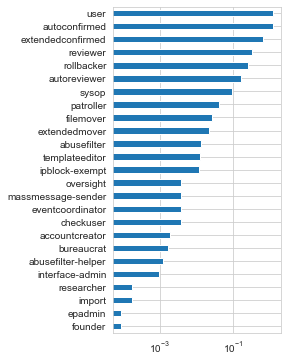

In [33]:
_s = (user_info_cleaned_df[group_types].sum()/11132.).sort_values()
_s.plot(kind='barh',logx=True,figsize=(3,6))

### German language edition - user processing

In [64]:
#de 
# df of the top users de
user_info = get_user_info(list(top_users_de.index),endpoint='de.wikipedia.org/w/api.php')
print(len(user_info))

_df0 = pd.DataFrame(user_info)
nonmissing_users = _df0[~_df0['editcount'].isnull()]['name'].values
missing_users = _df0[_df0['editcount'].isnull()]['name'].values
no_page_users = list()

print(len(list(nonmissing_users)),len(list(missing_users)),len(list(no_page_users)))

name_redirects = {}
for missing_user in missing_users:
    links_on_missing = get_links(missing_user,endpoint='de.wikipedia.org/w/api.php',userword='Benutzer')
    links_on_missing_1 = get_links(missing_user,endpoint='de.wikipedia.org/w/api.php',userword='Benutzerin')
    links_on_missing = links_on_missing + links_on_missing_1
    if len(links_on_missing) == 0:
        no_page_users.append(missing_user)
    else:
        redirected_name = [i for i in links_on_missing if 'Benutzer:' in i or 'Benutzerin' in i]
        if len(redirected_name) == 0:
            no_page_users.append(missing_user)
        else:
            name_redirects[missing_user] = redirected_name[0]

missing_user_info = get_user_info(list(name_redirects.values()),endpoint='de.wikipedia.org/w/api.php')
print(len(list(nonmissing_users)),len(missing_user_info),len(no_page_users))

with open('name_redirects_de.json','w',encoding='utf8') as f:
    json.dump(name_redirects,f)

3024
3024 0 0
3024 0 0


In [35]:
# apparently there are no missing users

In [65]:
# df of the top users de
_df0 = pd.DataFrame(user_info)
_df1 = _df0[~_df0['name'].isin(missing_users)]
_df2 = pd.DataFrame(missing_user_info)
user_info_df = pd.concat([_df1,_df2])
print(len(user_info_df))
print(len(no_page_users))
#print(top_users_de)

3024
0


In [66]:
group_types = list(set([j for i in user_info_df['groups'].dropna().values for j in i]) - set(['*']))
#_ix = user_info_df['groups'].dropna().index
#subgroup = user_info_df.ix[_ix]

for group in group_types:
    user_info_df[group] = user_info_df['groups'].apply(lambda x:group in x)

user_info_cleaned_df = user_info_df[[i for i in user_info_df.columns if i not in ['groups','*']]]
user_info_cleaned_df.to_csv('user_info_de.csv',encoding='utf8')
user_info_cleaned_df.head()

,userid,name,editcount,registration,gender,editor,checkuser,ipblock-exempt,autoconfirmed,oversight,user,interface-admin,bureaucrat,noratelimit,import,autoreview,sysop
0,127709,DerHexer,170006,None,male,True,False,False,True,False,True,False,False,False,False,False,True
1,44,Elian,27553,None,unknown,True,False,False,True,False,True,False,False,False,False,True,False
2,250642,Matthiasb,182922,2006-07-15T09:44:32Z,male,True,False,False,True,False,True,False,False,False,False,True,False
3,29427,Cepheiden,73006,None,unknown,True,False,False,True,False,True,False,False,False,False,True,False
4,91108,W!B:,276594,None,unknown,True,False,False,True,False,True,False,False,False,False,True,False


In [67]:
try:
    bots_test = user_info_cleaned_df[user_info_cleaned_df['bot'] == True]['name'].values
    print(bots_test)
except KeyError:
    print("No bots!")

No bots!


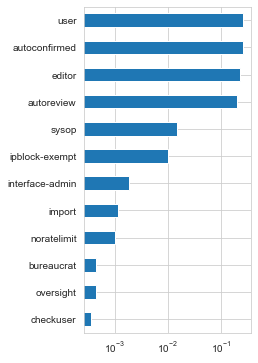

In [41]:
_s = (user_info_cleaned_df[group_types].sum()/11132.).sort_values()
_s.plot(kind='barh',logx=True,figsize=(3,6))

### Spanish language edition - user processing

In [57]:
#es - df of the top users
user_info = get_user_info(list(top_users_es.index),endpoint='es.wikipedia.org/w/api.php')
print(len(user_info))

_df0 = pd.DataFrame(user_info)
nonmissing_users = _df0[~_df0['editcount'].isnull()]['name'].values
missing_users = _df0[_df0['editcount'].isnull()]['name'].values
no_page_users = list()

print(len(list(nonmissing_users)),len(list(missing_users)),len(list(no_page_users)))

name_redirects = {}
for missing_user in missing_users:
    links_on_missing = get_links(missing_user,endpoint='es.wikipedia.org/w/api.php',userword='Usuario')
    links_on_missing_1 = get_links(missing_user,endpoint='es.wikipedia.org/w/api.php',userword='Usuaria')
    links_on_missing = links_on_missing + links_on_missing_1
    if len(links_on_missing) == 0:
        no_page_users.append(missing_user)
    else:
        redirected_name = [i for i in links_on_missing if 'Usuario:' in i or 'Usuaria' in i]
        if len(redirected_name) == 0:
            no_page_users.append(missing_user)
        else:
            name_redirects[missing_user] = redirected_name[0]

missing_user_info = get_user_info(list(name_redirects.values()),endpoint='es.wikipedia.org/w/api.php')
print(len(list(nonmissing_users)),len(missing_user_info),len(no_page_users))

with open('name_redirects_es.json','w',encoding='utf8') as f:
    json.dump(name_redirects,f)

890
890 0 0
890 0 0


In [43]:
# apparently there are no missing users
_df0 = pd.DataFrame(user_info)
_df1 = _df0[~_df0['name'].isin(missing_users)]
_df2 = pd.DataFrame(missing_user_info)
user_info_df = pd.concat([_df1,_df2])
print(len(user_info_df))
print(len(no_page_users))

890
0


In [44]:
group_types = list(set([j for i in user_info_df['groups'].dropna().values for j in i]) - set(['*']))
#_ix = user_info_df['groups'].dropna().index
#subgroup = user_info_df.ix[_ix]

for group in group_types:
    user_info_df[group] = user_info_df['groups'].apply(lambda x:group in x)

user_info_cleaned_df = user_info_df[[i for i in user_info_df.columns if i not in ['groups','*']]]
user_info_cleaned_df.to_csv('user_info_es.csv',encoding='utf8')
user_info_cleaned_df.head()

,userid,name,editcount,registration,gender,checkuser,ipblock-exempt,autopatrolled,autoconfirmed,rollbacker,oversight,patroller,user,bureaucrat,interface-admin,sysop
0,1122788,Hprmedina,29182,2009-06-21T04:23:57Z,male,False,False,False,True,True,False,True,True,False,False,False
1,80935,Paintman,30550,None,unknown,False,False,False,True,False,False,False,True,False,False,False
2,32328,Taichi,125624,None,male,False,False,False,True,False,False,False,True,True,False,True
3,2545358,Addbot,305587,2013-03-01T15:57:34Z,unknown,False,False,False,True,False,False,False,True,False,False,False
4,305784,Belgrano,20752,2007-02-09T14:08:22Z,male,False,False,False,True,False,False,False,True,False,False,False


In [45]:
try:
    bots_test = user_info_cleaned_df[user_info_cleaned_df['bot'] == True]['name'].values
    print(bots_test)
except KeyError:
    print("No bots!")

No bots!


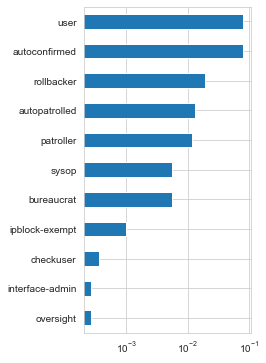

In [46]:
_s = (user_info_cleaned_df[group_types].sum()/11132.).sort_values()
_s.plot(kind='barh',logx=True,figsize=(3,6))

### French language edition - user processing

In [129]:
#fr - df of the top users
user_info = get_user_info(list(top_users_fr.index),endpoint='fr.wikipedia.org/w/api.php')
print(len(user_info))

_df0 = pd.DataFrame(user_info)
nonmissing_users = _df0[~_df0['editcount'].isnull()]['name'].values
missing_users = _df0[_df0['editcount'].isnull()]['name'].values
print(missing_users)

no_page_users = list()
print(_df0.head())

print(len(list(nonmissing_users)),len(list(missing_users)),len(list(no_page_users)))

name_redirects = {}
for missing_user in missing_users:
    # Utilisateur / Utilisatrice
    links_on_missing = get_links(missing_user,endpoint='fr.wikipedia.org/w/api.php',userword='Utilisateur')
    if len(links_on_missing) == 0:
        print(missing_user + " has no link on missing user page")
        no_page_users.append(missing_user)
    else:
        print(missing_user + " has a link on missing user page")
        redirected_name = [i for i in links_on_missing if 'Utilisateur:' in i]
        redirected_name_1 = [i for i in links_on_missing if 'Utilisatrice:' in i]
        if missing_user == 'Lotus 50':
            name_redirects[missing_user] = 'Utilisatrice:Mas003'
            continue
        if len(redirected_name) == 0:
            print("there is no page")
            no_page_users.append(missing_user)
        else:
            print("name redirect")
            name_redirects[missing_user] = redirected_name[0]

missing_user_info = get_user_info(list(name_redirects.values()),endpoint='fr.wikipedia.org/w/api.php')
print(len(list(nonmissing_users)),len(missing_user_info),len(no_page_users))

with open('name_redirects_fr.json','w',encoding='utf8') as f:
    json.dump(name_redirects,f)

print(missing_user_info)

1303
['Lotus 50']
     userid       name  editcount          registration  \
0  550436.0     Nouill   165503.0  2009-02-16T16:35:40Z   
1  460796.0  Racconish    70657.0  2008-09-28T14:37:15Z   
2  517206.0   Azurfrog   148408.0  2008-12-27T19:47:13Z   
3   13782.0    Apokrif    57669.0                  None   
4  621253.0     Lomita   506383.0  2009-06-15T11:45:47Z   

                                              groups   gender missing  
0            [*, user, autoconfirmed, autopatrolled]  unknown     NaN  
1  [rollbacker, *, user, autoconfirmed, autopatro...  unknown     NaN  
2     [sysop, *, user, autoconfirmed, autopatrolled]     male     NaN  
3  [ipblock-exempt, *, user, autoconfirmed, autop...  unknown     NaN  
4  [abusefilter, oversight, sysop, *, user, autoc...  unknown     NaN  
1302 1 0
Lotus 50
{'batchcomplete': '', 'query': {'pages': {'13517001': {'pageid': 13517001, 'ns': 2, 'title': 'Utilisateur:Lotus 50', 'links': [{'ns': 2, 'title': 'Utilisatrice:Mas003'}]}}}}
Lot

In [75]:
# apparently there are no missing users
_df0 = pd.DataFrame(user_info)
_df1 = _df0[~_df0['name'].isin(missing_users)]
_df2 = pd.DataFrame(missing_user_info)
user_info_df = pd.concat([_df1,_df2])
print(len(user_info_df))
print(len(no_page_users))

1303
0


In [76]:
group_types = list(set([j for i in user_info_df['groups'].dropna().values for j in i]) - set(['*']))
#_ix = user_info_df['groups'].dropna().index
#subgroup = user_info_df.ix[_ix]

for group in group_types:
    user_info_df[group] = user_info_df['groups'].apply(lambda x:group in x)

user_info_cleaned_df = user_info_df[[i for i in user_info_df.columns if i not in ['groups','*']]]
user_info_cleaned_df.to_csv('user_info_fr.csv',encoding='utf8')
user_info_cleaned_df.head()

,userid,name,editcount,registration,gender,abusefilter,checkuser,ipblock-exempt,autopatrolled,autoconfirmed,accountcreator,rollbacker,oversight,user,bureaucrat,transwiki,interface-admin,sysop
0,550436,Nouill,165472,2009-02-16T16:35:40Z,unknown,False,False,False,True,True,False,False,False,True,False,False,False,False
1,460796,Racconish,70616,2008-09-28T14:37:15Z,unknown,False,False,False,True,True,False,True,False,True,False,False,False,False
2,517206,Azurfrog,148408,2008-12-27T19:47:13Z,male,False,False,False,True,True,False,False,False,True,False,False,False,True
3,13782,Apokrif,57652,None,unknown,False,False,True,True,True,False,False,False,True,False,False,False,False
4,621253,Lomita,506336,2009-06-15T11:45:47Z,unknown,True,False,False,True,True,False,False,True,True,False,False,False,True


In [77]:
try:
    bots_test = user_info_cleaned_df[user_info_cleaned_df['bot'] == True]['name'].values
    print(bots_test)
except KeyError:
    print("No bots!")

No bots!


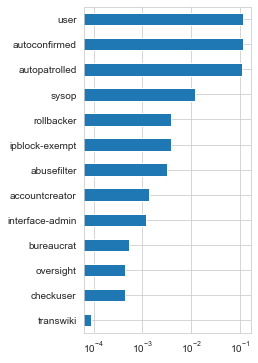

In [78]:
_s = (user_info_cleaned_df[group_types].sum()/11132.).sort_values()
_s.plot(kind='barh',logx=True,figsize=(3,6))

### Japanese language edition - user processing

In [79]:
#ja - df of the top users
user_info = get_user_info(list(top_users_ja.index),endpoint='ja.wikipedia.org/w/api.php')
print(len(user_info))

_df0 = pd.DataFrame(user_info)
nonmissing_users = _df0[~_df0['editcount'].isnull()]['name'].values
missing_users = _df0[_df0['editcount'].isnull()]['name'].values
no_page_users = list()

print(len(list(nonmissing_users)),len(list(missing_users)),len(list(no_page_users)))

name_redirects = {} 
for missing_user in missing_users:
    links_on_missing = get_links(missing_user,endpoint='ja.wikipedia.org/w/api.php',userword='利用者')
    if len(links_on_missing) == 0:
        no_page_users.append(missing_user)
    else:
        redirected_name = [i for i in links_on_missing if '利用者:' in i]
        if len(redirected_name) == 0:
            no_page_users.append(missing_user)
        else:
            name_redirects[missing_user] = redirected_name[0]

missing_user_info = get_user_info(list(name_redirects.values()),endpoint='ja.wikipedia.org/w/api.php')
print(len(list(nonmissing_users)),len(missing_user_info),len(no_page_users))

with open('name_redirects_ja.json','w',encoding='utf8') as f:
    json.dump(name_redirects,f)

1243
1243 0 0
1243 0 0


In [80]:
# apparently there are no missing users
_df0 = pd.DataFrame(user_info)
_df1 = _df0[~_df0['name'].isin(missing_users)]
_df2 = pd.DataFrame(missing_user_info)
user_info_df = pd.concat([_df1,_df2])
print(len(user_info_df))
print(len(no_page_users))

1243
0


In [81]:
group_types = list(set([j for i in user_info_df['groups'].dropna().values for j in i]) - set(['*']))
#_ix = user_info_df['groups'].dropna().index
#subgroup = user_info_df.ix[_ix]

for group in group_types:
    user_info_df[group] = user_info_df['groups'].apply(lambda x:group in x)

user_info_cleaned_df = user_info_df[[i for i in user_info_df.columns if i not in ['groups','*']]]
user_info_cleaned_df.to_csv('user_info_ja.csv',encoding='utf8')
user_info_cleaned_df.head()

,userid,name,editcount,registration,gender,abusefilter,checkuser,ipblock-exempt,autoconfirmed,oversight,eliminator,rollbacker,extendedconfirmed,user,bureaucrat,interface-admin,sysop
0,1601,Kurz,10949,None,male,False,False,False,True,False,False,False,True,True,False,False,False
1,34929,Aotake,15157,None,unknown,False,False,False,True,False,False,False,True,True,False,False,False
2,631644,タバコはマーダー,20583,2012-06-09T02:42:00Z,unknown,False,False,False,True,False,False,False,False,True,False,False,False
3,1881,Miya,32403,None,female,True,False,False,True,False,False,False,False,True,False,False,True
4,263159,Penn Station,60184,2008-11-23T08:06:06Z,unknown,True,True,False,True,True,False,False,False,True,True,True,True


In [82]:
try:
    bots_test = user_info_cleaned_df[user_info_cleaned_df['bot'] == True]['name'].values
    print(bots_test)
except KeyError:
    print("No bots!")

No bots!


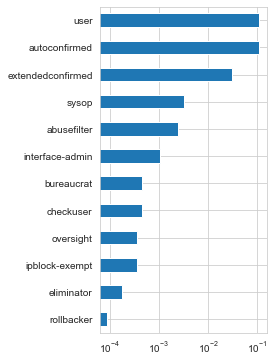

In [83]:
_s = (user_info_cleaned_df[group_types].sum()/11132.).sort_values()
_s.plot(kind='barh',logx=True,figsize=(3,6))

## Starts and ends

First, we compute a few starts and ends: first rule revision for that editor A in language edition X + their last rule revision (in 2019).

In [ ]:
# Load the things we exported


In [84]:
def get_user_contributions(usernames,endpoint,start,end):
    '''
    https://www.mediawiki.org/wiki/API:Usercontribs
    '''
    #if type(usernames) != list:
    #    raise ValueError('Usernames is not a list')

    query_params = {'action': 'query',
                    'format':'json',
                    'list': 'usercontribs',
                    #'ucprop':'ids|timestamp|title|comment|',
                    'ucstart':start,
                    'ucend':end,
                    'ucdir':'newer',
                    'uclimit':500}
    query_url = "https://{}".format(endpoint)

    user_contributions = list()
    
    if len(usernames) <= 50:
        query_params['ucuser'] = ''.join(usernames)
        json_response = requests.get(url = query_url, params = query_params).json()
        #print(json_response)
        user_contributions = json_response['query']['usercontribs']
    else:
        for chunk in chunks(usernames,50):
            query_params['ucuser'] = ''.join(chunk)
            json_response = requests.get(url = query_url, params = query_params).json()
            for i in json_response['query']['usercontribs']:
                user_contributions.append(i)

    while True:
        if 'continue' in json_response:
            query_continue_params = deepcopy(query_params)
            query_continue_params['uccontinue'] = json_response['continue']['uccontinue']
            #print(query_continue_params)
            json_response = requests.get(url = query_url, params = query_continue_params).json()
            if 'usercontribs' in json_response['query']:
                for i in json_response['query']['usercontribs']:
                    user_contributions.append(i)
        else:
            break

    return pd.DataFrame(user_contributions)

In [85]:
# test get_user_contributions
_records = top_users_en.reset_index().to_dict('records')[:10]

start = (_records[0]['ts_min'] - np.timedelta64(28,'D')).isoformat()
end = (_records[0]['ts_max'] + np.timedelta64(28,'D')).isoformat()

print(_records[0])
print(_records[0]['user'])

_temp = get_user_contributions(_records[0]['user'],start=start,end=end,endpoint='en.wikipedia.org/w/api.php')
print(_temp.shape)

{'user': 'SMcCandlish', 'revs': 19004, 'pages': 356, 'ts_min': Timestamp('2006-02-23 20:59:57+0000', tz='UTC'), 'ts_max': Timestamp('2020-07-25 03:40:39+0000', tz='UTC')}
SMcCandlish
(164830, 15)


In [86]:
pd.set_option('display.max_columns',10)
print(_temp.head())

userid         user  pageid     revid  parentid  ...   size  new  top  \
0  378390  SMcCandlish  302902  38252711  27318018  ...   1667  NaN  NaN   
1  378390  SMcCandlish  465885  38440036  34757743  ...    647  NaN  NaN   
2  378390  SMcCandlish  735538  38893537  37448499  ...   9056  NaN  NaN   
3  378390  SMcCandlish   42737  39431396  37964548  ...  10381  NaN  NaN   
4  378390  SMcCandlish   50023  39435508  39210217  ...  36268  NaN  NaN   

  texthidden suppressed  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

[5 rows x 15 columns]


Getting user contributions of the top users now, and grabbing the first set of revisions and last set of revisions in their editing history

In [88]:
# en
_records = top_users_en.reset_index().to_dict('records')

if not os.path.isdir('./user_start_en'):
    os.mkdir('./user_start_en')
if not os.path.isdir('./user_end_en'):
    os.mkdir('./user_end_en')

for i,user_dict in enumerate(_records):
    try:
        # start
        start = (user_dict['ts_min'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_min'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='en.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_start_en/user_start_{0}.tsv'.format(i),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!startrevs {}:{} failed'.format(i,user_dict['user']))
        pass

for i,user_dict in enumerate(_records):
    try:
        # end
        start = (user_dict['ts_max'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_max'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='en.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_end_en/user_end_{0}.tsv'.format(i),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!endrevs {}:{} failed'.format(i,user_dict['user']))
        pass

d
!!!endrevs 13277:IfYouDoIfYouDon't failed
!!!endrevs 13278:Tbtkorg failed
!!!endrevs 13279:Idyllic press failed
!!!endrevs 13280:Ivan Pozdeev failed
!!!endrevs 13281:CFynn failed
!!!endrevs 13282:Afaber012 failed
!!!endrevs 13283:Jahaza failed
!!!endrevs 13284:Jagislaqroo failed
!!!endrevs 13285:StuartBrady failed
!!!endrevs 13286:StuartDouglas failed
!!!endrevs 13287:StuartH failed
!!!endrevs 13288:Stude62 failed
!!!endrevs 13289:Jacquerie27 failed
!!!endrevs 13290:Jackytar failed
!!!endrevs 13291:Stultiwikia failed
!!!endrevs 13292:Jackftwist failed
!!!endrevs 13293:Jackfirst failed
!!!endrevs 13294:Störm failed
!!!endrevs 13295:JackTheVicar failed
!!!endrevs 13296:Subsume failed
!!!endrevs 13297:Subtropical-man failed
!!!endrevs 13298:Subzerosmokerain failed
!!!endrevs 13299:Agent008 failed
!!!endrevs 13300:Sue Wallace failed
!!!endrevs 13301:Sugarbat failed
!!!endrevs 13302:Sumahoy failed
!!!endrevs 13303:Sumbuddi failed
!!!endrevs 13304:C mon failed
!!!endrevs 13305:Summichum fa

In [89]:
# de
_records = top_users_de.reset_index().to_dict('records')

if not os.path.isdir('./user_start_de'):
    os.mkdir('./user_start_de')
if not os.path.isdir('./user_end_de'):
    os.mkdir('./user_end_de')

for i,user_dict in enumerate(_records):
    try:
        # start
        start = (user_dict['ts_min'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_min'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='de.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_start_de/user_start_{0}.tsv'.format(i),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!startrevs {}:{} failed'.format(i,user_dict['user']))
        pass

for i,user_dict in enumerate(_records):
    try:
        # end
        start = (user_dict['ts_max'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_max'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='de.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_end_de/user_end_{0}.tsv'.format(i),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!endrevs {}:{} failed'.format(i,user_dict['user']))
        pass

!!!startrevs 0:DerHexer failed
!!!startrevs 1:Elian failed
!!!startrevs 2:Matthiasb failed
!!!startrevs 3:Cepheiden failed
!!!startrevs 4:W!B: failed
!!!startrevs 5:Wiegels failed
!!!startrevs 6:Sebmol failed
!!!startrevs 7:PerfektesChaos failed
!!!startrevs 8:Lómelinde failed
!!!startrevs 9:Rax failed
!!!startrevs 10:Asthma failed
!!!startrevs 11:Eneas failed
!!!startrevs 12:Benatrevqre failed
!!!startrevs 13:Ziko failed
!!!startrevs 14:Southpark failed
!!!startrevs 15:Geitost failed
!!!startrevs 16:SDB failed
!!!startrevs 17:Harry8 failed
!!!startrevs 18:Tilla failed
!!!startrevs 19:Magiers failed
!!!startrevs 20:Carbidfischer failed
!!!startrevs 21:HaeB failed
!!!startrevs 22:Gestumblindi failed
!!!startrevs 23:Kh80 failed
!!!startrevs 24:Fossa failed
!!!startrevs 25:Verzettelung failed
!!!startrevs 26:Ralf Roletschek failed
!!!startrevs 27:JakobVoss failed
!!!startrevs 28:Ulrich.fuchs failed
!!!startrevs 29:Tolanor failed
!!!startrevs 30:Rosenkohl failed
!!!startrevs 31:Gunther fai

In [132]:
# fixing the failed ones
# de start revs 0 - 165
_records = top_users_de.reset_index().to_dict('records')[:165]

for i,user_dict in enumerate(_records):
    try:
        # start
        start = (user_dict['ts_min'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_min'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='de.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_start_de/user_start_{0}.tsv'.format(i),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!startrevs {}:{} failed'.format(i,user_dict['user']))
        pass


In [135]:
# fixing the failed ones
# enstart revs 12760 - ...
_records = top_users_en.reset_index().to_dict('records')[:1100]

if not os.path.isdir('./user_start_en'):
    os.mkdir('./user_start_en')
if not os.path.isdir('./user_end_en'):
    os.mkdir('./user_end_en')

for i,user_dict in enumerate(_records):
    try:
        # start
        start = (user_dict['ts_min'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_min'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='en.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_start_en/user_start_{0}.tsv'.format(i),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!startrevs {}:{} failed'.format(i,user_dict['user']))
        pass

In [136]:
# fixing the failed ones
# enstart revs 12760 - ...
_records = top_users_en.reset_index().to_dict('records')[12760:]

if not os.path.isdir('./user_start_en'):
    os.mkdir('./user_start_en')
if not os.path.isdir('./user_end_en'):
    os.mkdir('./user_end_en')

for i,user_dict in enumerate(_records):
    try:
        # start
        start = (user_dict['ts_min'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_min'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='en.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_start_en/user_start_{0}.tsv'.format(i+12760),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!startrevs {}:{} failed'.format(i,user_dict['user']))
        pass

In [137]:
# fixing the failed ones
# en end revs 9 - ...
_records = top_users_en.reset_index().to_dict('records')[9:]

for i,user_dict in enumerate(_records):
    try:
        # end
        start = (user_dict['ts_max'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_max'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='en.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_end_en/user_end_{0}.tsv'.format(i+9),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!endrevs {}:{} failed'.format(i,user_dict['user']))
        pass

In [90]:
# es
_records = top_users_es.reset_index().to_dict('records')

if not os.path.isdir('./user_start_es'):
    os.mkdir('./user_start_es')
if not os.path.isdir('./user_end_es'):
    os.mkdir('./user_end_es')

for i,user_dict in enumerate(_records):
    try:
        # start
        start = (user_dict['ts_min'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_min'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='es.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_start_es/user_start_{0}.tsv'.format(i),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!startrevs {}:{} failed'.format(i,user_dict['user']))
        pass

for i,user_dict in enumerate(_records):
    try:
        # end
        start = (user_dict['ts_max'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_max'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='es.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_end_es/user_end_{0}.tsv'.format(i),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!endrevs {}:{} failed'.format(i,user_dict['user']))
        pass

In [130]:
#fr
_records = top_users_fr.reset_index().to_dict('records')

if not os.path.isdir('./user_start_fr'):
    os.mkdir('./user_start_fr')
if not os.path.isdir('./user_end_fr'):
    os.mkdir('./user_end_fr')

for i,user_dict in enumerate(_records):
    try:
        # start
        start = (user_dict['ts_min'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_min'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='fr.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_start_fr/user_start_{0}.tsv'.format(i),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!startrevs {}:{} failed'.format(i,user_dict['user']))
        pass

for i,user_dict in enumerate(_records):
    try:
        # end
        start = (user_dict['ts_max'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_max'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='fr.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_end_fr/user_end_{0}.tsv'.format(i),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!endrevs {}:{} failed'.format(i,user_dict['user']))
        pass

In [92]:
#ja
_records = top_users_ja.reset_index().to_dict('records')

if not os.path.isdir('./user_start_ja'):
    os.mkdir('./user_start_ja')
if not os.path.isdir('./user_end_ja'):
    os.mkdir('./user_end_ja')

for i,user_dict in enumerate(_records):
    try:
        # start
        start = (user_dict['ts_min'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_min'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='ja.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_start_ja/user_start_{0}.tsv'.format(i),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!startrevs {}:{} failed'.format(i,user_dict['user']))
        pass

for i,user_dict in enumerate(_records):
    try:
        # end
        start = (user_dict['ts_max'] - np.timedelta64(28,'D')).isoformat()
        end = (user_dict['ts_max'] + np.timedelta64(28,'D')).isoformat()
        _df = get_user_contributions(user_dict['user'],endpoint='ja.wikipedia.org/w/api.php',start=start,end=end)
        _df.to_csv('./user_end_ja/user_end_{0}.tsv'.format(i),sep='\t',encoding='utf8')
    except KeyboardInterrupt:
        raise
    except:
        print(u'!!!endrevs {}:{} failed'.format(i,user_dict['user']))
        pass

This cleans and combines user revisions (start)

In [138]:
# for each language edition, clean and combine 

_datadir = './user_start_ja/'
# from brian's code:
user_start_dict = dict()
for filename in [i for i in os.listdir(_datadir) if 'tsv' in i and 'user' in i and 'start' in i]:
    _df = pd.read_csv(_datadir + filename,sep='\t',encoding='utf8',index_col=0)
    user_start_dict[filename[:-4]] = _df
user_start_rev_df = pd.concat(user_start_dict.values()).reset_index(drop=True)
user_start_rev_df['timestamp'] = pd.to_datetime(user_start_rev_df['timestamp'])
user_start_rev_df['date'] = user_start_rev_df['timestamp'].apply(lambda x:x.date())
user_start_rev_df['year'] = user_start_rev_df['date'].apply(lambda x:x.year)
user_start_rev_df.to_csv('user_start_revisions_ja.tsv',sep='\t',encoding='utf8')
user_start_rev_df.tail()

,userid,user,pageid,revid,parentid,...,texthidden,commenthidden,suppressed,date,year
726644,87382,移動用アカウント,3859,8734275,6157322,...,NaN,NaN,NaN,2006-11-08,2006
726645,87382,移動用アカウント,293216,8750637,8749654,...,NaN,NaN,NaN,2006-11-09,2006
726646,87382,移動用アカウント,758617,8750638,0,...,NaN,NaN,NaN,2006-11-09,2006
726647,87382,移動用アカウント,8292,8750648,8748829,...,NaN,NaN,NaN,2006-11-09,2006
726648,87382,移動用アカウント,293216,8750787,8750637,...,NaN,NaN,NaN,2006-11-09,2006


In [139]:
_datadir = './user_start_en/'
# from brian's code:
user_start_dict = dict()
for filename in [i for i in os.listdir(_datadir) if 'tsv' in i and 'user' in i and 'start' in i]:
    _df = pd.read_csv(_datadir + filename,sep='\t',encoding='utf8',index_col=0)
    user_start_dict[filename[:-4]] = _df
user_start_rev_df = pd.concat(user_start_dict.values()).reset_index(drop=True)
user_start_rev_df['timestamp'] = pd.to_datetime(user_start_rev_df['timestamp'])
user_start_rev_df['date'] = user_start_rev_df['timestamp'].apply(lambda x:x.date())
user_start_rev_df['year'] = user_start_rev_df['date'].apply(lambda x:x.year)
user_start_rev_df.to_csv('user_start_revisions_en.tsv',sep='\t',encoding='utf8')
user_start_rev_df.tail()

,userid,user,pageid,revid,parentid,...,texthidden,commenthidden,suppressed,date,year
13577345,1761937,Instinct,3997995,199148373,199128898,...,NaN,NaN,NaN,2008-03-18,2008
13577346,1761937,Instinct,16284542,199148561,198757228,...,NaN,NaN,NaN,2008-03-18,2008
13577347,1761937,Instinct,16284542,199148705,199148561,...,NaN,NaN,NaN,2008-03-18,2008
13577348,1761937,Instinct,16284542,199149676,199148705,...,NaN,NaN,NaN,2008-03-18,2008
13577349,1761937,Instinct,16344472,199149907,198994853,...,NaN,NaN,NaN,2008-03-18,2008


In [140]:
_datadir = './user_start_es/'
# from brian's code:
user_start_dict = dict()
for filename in [i for i in os.listdir(_datadir) if 'tsv' in i and 'user' in i and 'start' in i]:
    _df = pd.read_csv(_datadir + filename,sep='\t',encoding='utf8',index_col=0)
    user_start_dict[filename[:-4]] = _df
user_start_rev_df = pd.concat(user_start_dict.values()).reset_index(drop=True)
user_start_rev_df['timestamp'] = pd.to_datetime(user_start_rev_df['timestamp'])
user_start_rev_df['date'] = user_start_rev_df['timestamp'].apply(lambda x:x.date())
user_start_rev_df['year'] = user_start_rev_df['date'].apply(lambda x:x.year)
user_start_rev_df.to_csv('user_start_revisions_es.tsv',sep='\t',encoding='utf8')
user_start_rev_df.tail()

,userid,user,pageid,revid,parentid,...,texthidden,suppressed,commenthidden,date,year
1166231,114003,Fidelmoquegua,1222480,11899959,11899912,...,NaN,NaN,NaN,2007-10-08,2007
1166232,114003,Fidelmoquegua,1222484,11899968,0,...,NaN,NaN,NaN,2007-10-08,2007
1166233,114003,Fidelmoquegua,515488,11900046,11898805,...,NaN,NaN,NaN,2007-10-08,2007
1166234,114003,Fidelmoquegua,726599,11900114,11897597,...,NaN,NaN,NaN,2007-10-08,2007
1166235,114003,Fidelmoquegua,1226530,11945962,0,...,NaN,NaN,NaN,2007-10-09,2007


In [141]:
_datadir = './user_start_de/'
# from brian's code:
user_start_dict = dict()
for filename in [i for i in os.listdir(_datadir) if 'tsv' in i and 'user' in i and 'start' in i]:
    _df = pd.read_csv(_datadir + filename,sep='\t',encoding='utf8',index_col=0)
    user_start_dict[filename[:-4]] = _df
user_start_rev_df = pd.concat(user_start_dict.values()).reset_index(drop=True)
user_start_rev_df['timestamp'] = pd.to_datetime(user_start_rev_df['timestamp'])
user_start_rev_df['date'] = user_start_rev_df['timestamp'].apply(lambda x:x.date())
user_start_rev_df['year'] = user_start_rev_df['date'].apply(lambda x:x.year)
user_start_rev_df.to_csv('user_start_revisions_de.tsv',sep='\t',encoding='utf8')
user_start_rev_df.tail()

,userid,user,pageid,revid,parentid,...,suppressed,top,commenthidden,date,year
2108178,14995,Marbot,891691,9130612,8803288,...,NaN,NaN,NaN,2005-09-07,2005
2108179,14995,Marbot,917671,9130686,0,...,NaN,NaN,NaN,2005-09-07,2005
2108180,14995,Marbot,874031,9130714,8803312,...,NaN,NaN,NaN,2005-09-07,2005
2108181,14995,Marbot,917671,9131267,9130686,...,NaN,NaN,NaN,2005-09-07,2005
2108182,14995,Marbot,629083,9131975,8982695,...,NaN,NaN,NaN,2005-09-07,2005


In [142]:
_datadir = './user_start_fr/'
# from brian's code:
user_start_dict = dict()
for filename in [i for i in os.listdir(_datadir) if 'tsv' in i and 'user' in i and 'start' in i]:
    _df = pd.read_csv(_datadir + filename,sep='\t',encoding='utf8',index_col=0)
    user_start_dict[filename[:-4]] = _df
user_start_rev_df = pd.concat(user_start_dict.values()).reset_index(drop=True)
user_start_rev_df['timestamp'] = pd.to_datetime(user_start_rev_df['timestamp'])
user_start_rev_df['date'] = user_start_rev_df['timestamp'].apply(lambda x:x.date())
user_start_rev_df['year'] = user_start_rev_df['date'].apply(lambda x:x.year)
user_start_rev_df.to_csv('user_start_revisions_fr.tsv',sep='\t',encoding='utf8')
user_start_rev_df.tail()

,userid,user,pageid,revid,parentid,...,texthidden,commenthidden,suppressed,date,year
1477297,1629939,YotaMoteuchi,9576089,120653949,120653937,...,NaN,NaN,NaN,2015-11-20,2015
1477298,1629939,YotaMoteuchi,9576103,120665359,120551919,...,NaN,NaN,NaN,2015-11-21,2015
1477299,1629939,YotaMoteuchi,39437,120700589,120597667,...,NaN,NaN,NaN,2015-11-22,2015
1477300,1629939,YotaMoteuchi,28095,120702323,120607616,...,NaN,NaN,NaN,2015-11-22,2015
1477301,1629939,YotaMoteuchi,28095,120708343,120702323,...,NaN,NaN,NaN,2015-11-22,2015


## Exported and/or on disk
... things we need for analysis to disk. For each language edition:
- all revisions for rule / rule talk pages
- all users, top users
    - all of their revisions to the rule pages (subset from all revisions)
- all bots, top bots
    - all of their revisions to the rule pages (subset from all revisions)
- all ip editors, top ip editors
    - all of their revisions to the rule pages (subset from all revisions)

In [113]:
# checking if there really are no missing ones in non-english wikipedias

user_info = get_user_info(list(top_users_en.index),endpoint='en.wikipedia.org/w/api.php')
print(len(user_info))

_df0 = pd.DataFrame(user_info)
_sorted = _df0.sort_values( by='editcount', ascending=True, na_position='first' )
print(_sorted.head(10))


13858
      userid                                    name  editcount registration  \
1628     NaN                               PeeJay2K3        NaN          NaN   
1750     NaN                         142.160.131.202        NaN          NaN   
4000     NaN                          195.40.200.146        NaN          NaN   
4450     NaN                            67.14.236.50        NaN          NaN   
4500     NaN                           142.160.89.97        NaN          NaN   
5113     NaN                                      GT        NaN          NaN   
6300     NaN                          174.141.182.82        NaN          NaN   
6301     NaN                            174.3.98.236        NaN          NaN   
6550     NaN                            62.178.100.7        NaN          NaN   
7600     NaN  2601:586:4405:38E6:8C10:AED4:7F56:22F5        NaN          NaN   

     groups gender missing invalid  
1628    NaN    NaN             NaN  
1750    NaN    NaN     NaN          
40

In [119]:
user_info = get_user_info(list(top_users_es.index),endpoint='es.wikipedia.org/w/api.php')
print(len(user_info))

_df0 = pd.DataFrame(user_info)
_sorted = _df0.sort_values( by='editcount', ascending=True, na_position='first' )
print(_sorted.head(10))

890
      userid                       name  editcount          registration  \
439  4850052                      Edgar          0  2017-12-12T20:19:33Z   
835   361659                  Palomasoy          3  2007-04-09T17:00:40Z   
862  1152097                     Ansoni          4  2009-07-19T19:15:18Z   
753   175070            Afroditax100pre          5  2006-07-04T21:07:49Z   
743   104196          Guillecaballero 4          6  2006-02-28T17:18:00Z   
754   241183            Walter dolorier          6  2006-10-22T04:28:08Z   
848  5707282  Keily Sofía Ruano Guevara         11  2020-01-25T17:18:13Z   
881   331077                  Saidverse         12  2007-03-10T20:35:13Z   
831  5162986             Desconocido 12         13  2018-09-24T20:28:54Z   
742   894475                    Neolari         13  2008-11-22T14:41:14Z   

        groups   gender  
439  [*, user]  unknown  
835  [*, user]  unknown  
862  [*, user]  unknown  
753  [*, user]  unknown  
743  [*, user]  unknown  
754

In [120]:
missing_users = _df0[_df0['editcount'].isnull()]['name'].values
print(missing_users)

[]


In [116]:
user_info = get_user_info(list(top_users_de.index),endpoint='de.wikipedia.org/w/api.php')
print(len(user_info))

_df0 = pd.DataFrame(user_info)
_sorted = _df0.sort_values( by='editcount', ascending=True, na_position='first' )
print(_sorted.head(25))

3024
       userid                    name  editcount          registration  \
2766  2807580                Melsaran          0  2017-12-13T11:22:07Z   
2273  1215965            Cambalachero          2  2011-04-26T18:00:55Z   
2563  3044657             Pongsug1150          3  2018-10-22T21:56:30Z   
2676   568702              PhilKnight          4  2008-06-07T20:57:14Z   
2499   202918                   Dilos          5  2006-03-25T13:23:02Z   
2498  2381259               Dilchdran          5  2016-03-09T10:17:31Z   
2526   574601               Visari123          5  2008-06-20T21:45:44Z   
2578  1353068                Q2012J05          6  2012-01-05T20:39:43Z   
2439   122959               BurkhardS          6                  None   
2966   609108             SMcCandlish          6  2008-09-08T15:57:20Z   
2825  1332384               Seifghazi          7  2011-11-25T17:12:55Z   
1288  2320227   Ich mache Seiten leer          8  2015-12-12T13:11:50Z   
2259   497195           Azeton~de

In [122]:
user_info = get_user_info(list(top_users_fr.index),endpoint='fr.wikipedia.org/w/api.php')
print(len(user_info))

_df0 = pd.DataFrame(user_info)
_sorted = _df0.sort_values( by='editcount', ascending=True, na_position='first' )
print(_sorted.head(5))

1303
         userid           name  editcount          registration  \
297         NaN       Lotus 50        NaN                   NaN   
895   2253514.0           Buzz        0.0  2015-06-09T23:05:48Z   
365   2978977.0  (Former user)        0.0  2017-12-12T19:27:36Z   
1297   407746.0   Bambambigolo        1.0  2008-06-03T19:13:13Z   
1271  3519916.0     Jeanevan12        4.0  2019-07-13T07:01:23Z   

                        groups   gender missing  
297                        NaN      NaN          
895   [*, user, autoconfirmed]  unknown     NaN  
365   [*, user, autoconfirmed]  unknown     NaN  
1297  [*, user, autoconfirmed]  unknown     NaN  
1271  [*, user, autoconfirmed]  unknown     NaN  


In [123]:
missing_users = _df0[_df0['editcount'].isnull()]['name'].values
print(missing_users)

['Lotus 50']


In [121]:
user_info = get_user_info(list(top_users_ja.index),endpoint='ja.wikipedia.org/w/api.php')
print(len(user_info))

_df0 = pd.DataFrame(user_info)
_sorted = _df0.sort_values( by='editcount', ascending=True, na_position='first' )
print(_sorted.head(25))

1243
       userid            name  editcount          registration  \
1171   161703          ツカジーニー          2  2007-10-04T23:50:13Z   
781   1504861          내세요를ㅠ논          6  2019-06-23T08:55:05Z   
1181   218980    Foppard22311          7  2008-06-10T00:00:08Z   
1199    11153             ジンボ          7                  None   
1202   338934           アイボリー          7  2009-08-17T04:53:01Z   
501   1677727       金沢のバスオタ 1          8  2020-07-24T05:19:45Z   
1056   685981         Sasa-tr          8  2012-12-04T00:38:42Z   
1006    93752           神崎ゆきや          8  2006-11-11T04:02:38Z   
811    134667       プロ猿ファー・ゴル         10  2007-05-27T05:57:53Z   
974    361602      Everystory         11  2009-11-02T12:50:15Z   
855     78958      Shortshift         13  2006-08-31T17:22:09Z   
981    672397           高橋 ヒロ         13  2012-10-21T01:19:53Z   
1189  1006357          ポイポイ青年         14  2015-08-16T01:26:17Z   
1200  1306856          Igojin         14  2018-02-16T10:49:01Z   
1223 